# Imports

In [1]:
%matplotlib inline

from scipy.misc  import imresize

from keras.preprocessing import image
from keras.models        import Model
from keras.layers        import Input
from keras.layers        import Add
from keras.layers        import Convolution2D
from keras.layers        import Deconvolution2D
from keras.layers        import BatchNormalization
from keras.layers        import Activation
from keras.layers        import Convolution2DTranspose
from keras.layers        import UpSampling2D
from keras.optimizers    import Adam
from keras.callbacks     import ModelCheckpoint
from keras.callbacks     import LearningRateScheduler

import keras.backend     as K
import numpy             as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def limit_mem():
    cfg                          = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config = cfg))
limit_mem()

# Definitions and helper functions

Path and constant definitions

In [3]:
image_folder   = '../../data/fractal_zooms/'
batch_size     = 4
preprocess     = lambda x: (x - 127.5) / 127.5
small_shape    = (128, 192)
big_shape      = (256, 384)
epochs         = 500
start_lr       = 1e-3
end_lr         = 1e-6
learning_rates = np.linspace(start_lr, end_lr, epochs)
cp_period      = 100

A small helper function to compare two sets of images side by side.

In [4]:
def visualize(arrays, nb_row):
    num_arrays = len(arrays)
    plt.figure(figsize = (17, 17))
    for i in range(nb_row):
        for j in range(num_arrays):
            plt.subplot(nb_row, num_arrays, num_arrays * i + j + 1)
            plt.imshow(arrays[j][i].squeeze(), cmap = 'gray')

We use an `ImageDataGenerator` to load batch of images from the disk. We also create a custom wrapper to generate image couples of the form (small_resolution_image, high_resolution_image). 

In [5]:
generator       = image.ImageDataGenerator(preprocessing_function = preprocess)
flow_parameters = {
    'class_mode' : None,
    'target_size': big_shape,
    'color_mode' : 'grayscale',
    'batch_size' : batch_size
}
train_flow = generator.flow_from_directory(directory = image_folder + 'train/', **flow_parameters)
valid_flow = generator.flow_from_directory(directory = image_folder + 'test/', **flow_parameters)

Found 45000 images belonging to 1 classes.
Found 5000 images belonging to 1 classes.


In [6]:
def data_generator(flow, interp = 'nearest'):
    while True:
        output_images = next(flow)
        resize_image  = [imresize(output_images[i].squeeze(), small_shape, interp = interp) for i in range(output_images.shape[0])]
        input_images  = np.expand_dims(np.stack(resize_image), -1)
        
        yield (input_images, output_images)

Image loading and visualization test.

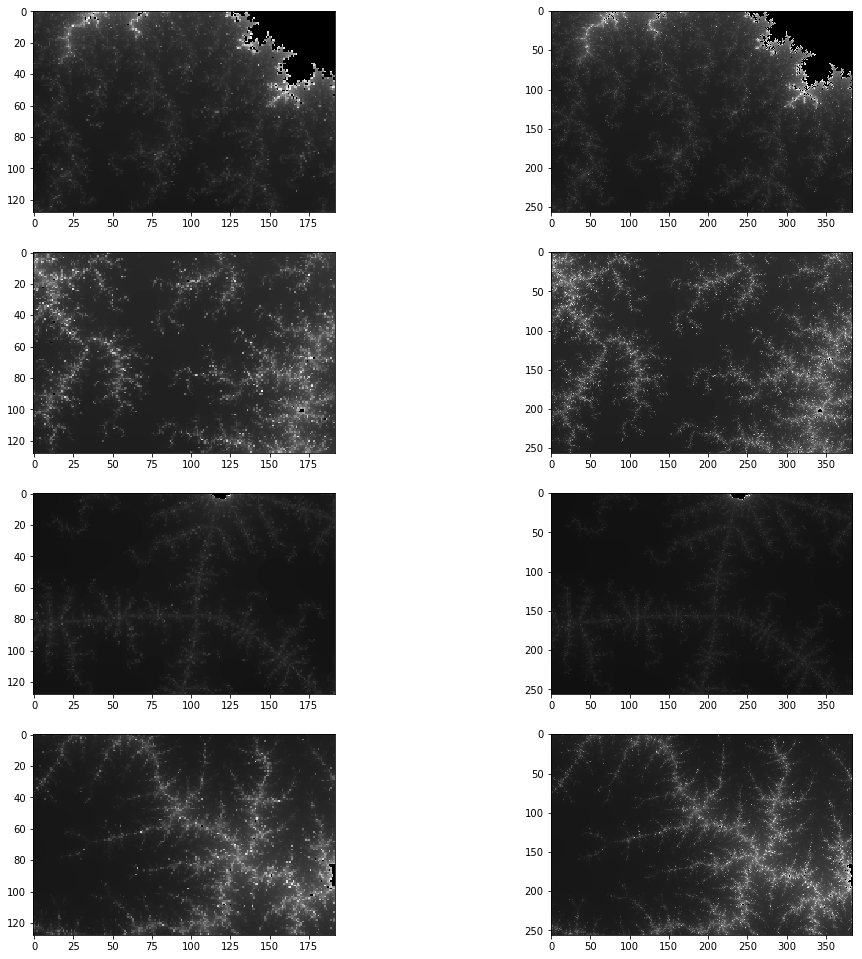

In [7]:
train_data_gen            = data_generator(train_flow)
valid_data_gen            = data_generator(valid_flow)
input_array, output_array = next(train_data_gen)
visualize([input_array, output_array], min(5, batch_size))

# Model definition

## Callbacks creation

### Model checkpoint callback

Creation of the model checkpoint callback.

In [8]:
checkpoint_callback = ModelCheckpoint('../models/super_resolution.epoch_{epoch:02d}.h5', period = cp_period)

## Learning rate annealing callback

This callback will make the learning rate decrease linearly along the epochs. It could also be interesting to try a [cyclical learning rate](https://arxiv.org/abs/1506.01186) as it seems to generaly improves convergence speed. 

In [9]:
def schedule(epoch):
    return learning_rates[epoch]

learning_rate_callback = LearningRateScheduler(schedule)

## Architecture

The architecture of the network comes from the article [Perceptual Losses for Real-Time Style Transfer and Super-Resolution](https://arxiv.org/abs/1603.08155). In this first example, a simple mean squared error on the pixel values is used in place of the perceptual loss. Another network in this repository will contain further exploration of the perceptual loss applied to this problem.  

In [10]:
def convolution_block(inp, filter_size = 3, nb_filters = 64, activation = True):
    x = Convolution2D(nb_filters, (filter_size, filter_size), strides = (1, 1), padding = 'same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) if activation else x
    
    return x

In [11]:
def residual_block(inp, nb_filders = 64):
    x = convolution_block(inp, nb_filders)
    x = convolution_block(x  , nb_filders, activation = False)
    x = Add()([inp, x])
    
    return x

Now for the part the of the network that increases the size of the picture, there is multiple choices. The one presented in the original is the deconvolution (or more correctly fractionnaly strided convolution). This kind of layer seem to produce [checkerboard patterns](http://distill.pub/2016/deconv-checkerboard/) and a solution to this problem is to use upsampling and regular convolutions. The two choices are implemented here. 

In [12]:
def deconvolution_block(inp, nb_filters = 64):
    x = Convolution2DTranspose(nb_filters, (3, 3), strides = (2, 2), padding = 'same')(inp)
    x = BatchNormalization()(x)
    
    return x

In [13]:
def upsampling_block(inp, nb_filter = 64):
    x = UpSampling2D()(inp)
    x = Convolution2D(nb_filter, (3, 3), strides = (1, 1), padding = 'same')(x)
    x = BatchNormalization()(x)
    
    return x

In [14]:
def create_model_deconvolution(input_shape):
    inp = Input(shape = input_shape + (1,))
    x   = convolution_block(inp, filter_size = 9, nb_filters = 64)
    for _ in range(4):
        x = residual_block(x)
    x     = deconvolution_block(x)
    x     = Convolution2D(1, (9, 9), strides = (1, 1), padding = 'same')(x)
    x     = Activation('tanh')(x)
    model = Model(inp, x)

    return model

In [15]:
def create_model_upsampling(input_shape):
    inp = Input(shape = input_shape + (1,))
    x   = convolution_block(inp, filter_size = 9, nb_filters = 64)
    for _ in range(4):
        x = residual_block(x)
    x     = upsampling_block(x)
    x     = Convolution2D(1, (9, 9), strides = (1, 1), padding = 'same')(x)
    x     = Activation('tanh')(x)
    model = Model(inp, x)

    return model

In [16]:
model = create_model_deconvolution(small_shape)
# model = create_model_upsampling(small_shape)
model.compile(optimizer = Adam(1e-3), loss = 'mse')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 192, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 192, 64)  5248        input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 192, 64)  256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128, 192, 64)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [17]:
fit_parameters = {
    'epochs'           : epochs,
    'generator'        : train_data_gen,
    'steps_per_epoch'  : 20,
    'validation_data'  : valid_data_gen,
    'validation_steps' : 10,
    'callbacks'        : [checkpoint_callback, learning_rate_callback],
    'verbose'          : 2
}

In [18]:
model.fit_generator(**fit_parameters)

/home/rodgzilla/Documents/machine_learning/keras/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/500
56s - loss: 0.5167 - val_loss: 2.8227
Epoch 2/500
45s - loss: 0.2921 - val_loss: 1.7210
Epoch 3/500
45s - loss: 0.2573 - val_loss: 1.4632
Epoch 4/500
44s - loss: 0.2301 - val_loss: 0.9971
Epoch 5/500
44s - loss: 0.1878 - val_loss: 1.0928
Epoch 6/500
44s - loss: 0.1377 - val_loss: 0.2007
Epoch 7/500
44s - loss: 0.0675 - val_loss: 0.1482
Epoch 8/500
44s - loss: 0.0539 - val_loss: 0.2260
Epoch 9/500
44s - loss: 0.0699 - val_loss: 0.1103
Epoch 10/500
44s - loss: 0.0517 - val_loss: 0.0999
Epoch 11/500
44s - loss: 0.0431 - val_loss: 0.0613
Epoch 12/500
44s - loss: 0.0475 - val_loss: 0.0753
Epoch 13/500
44s - loss: 0.0386 - val_loss: 0.0591
Epoch 14/500
44s - loss: 0.0426 - val_loss: 0.0370
Epoch 15/500
44s - loss: 0.0249 - val_loss: 0.0244
Epoch 16/500
44s - loss: 0.0248 - val_loss: 0.0284
Epoch 17/500
44s - loss: 0.0446 - val_loss: 0.0415
Epoch 18/500
44s - loss: 0.0485 - val_loss: 0.0576
Epoch 19/500
44s - loss: 0.0373 - val_loss: 0.0195
Epoch 20/500
45s - loss: 0.0251 - val_lo

In [19]:
model.save('../models/super_resolution_deconvolution.h5')

Now let's visualize the results of the super-resolutions produced by the network. In the following figure, the first, second and third columns contains respectively low resolution image, corresponding high resolution image and result of the super-resolution on the low resolution image.

/home/rodgzilla/Documents/machine_learning/keras/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


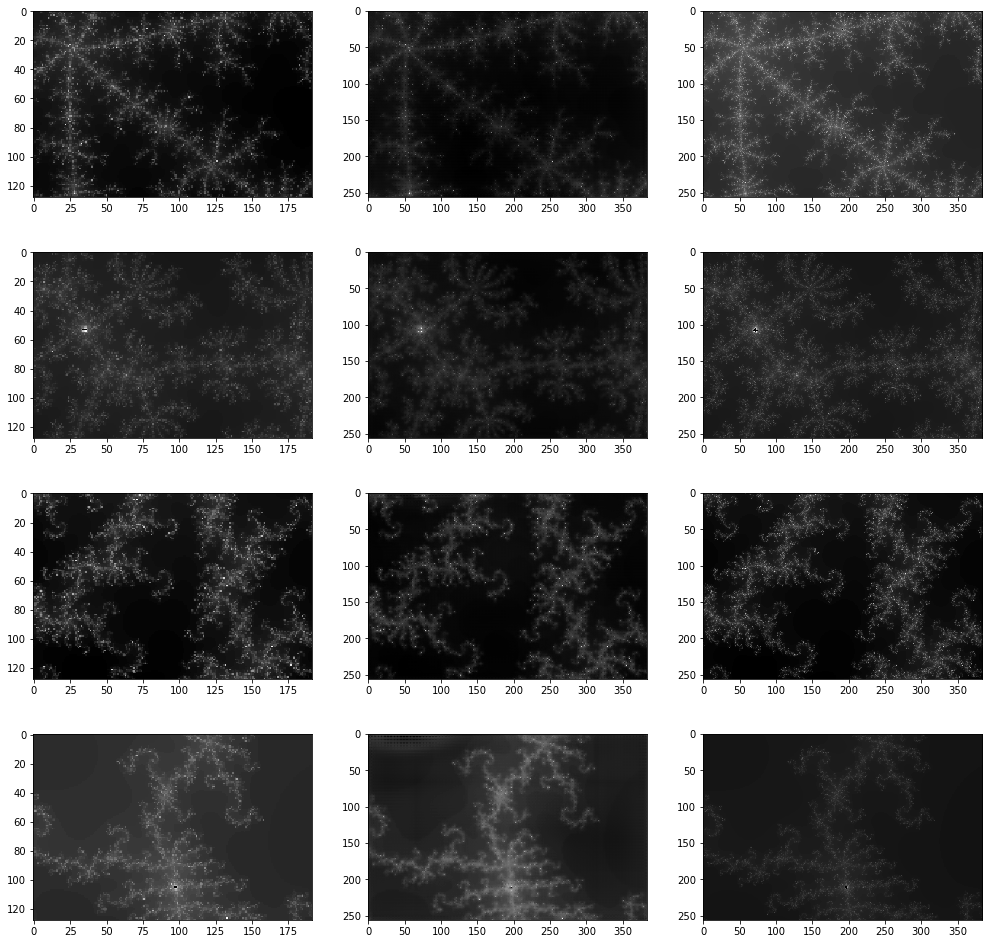

In [20]:
small_img, big_img = next(valid_data_gen)
big_img_pred       = model.predict(small_img, batch_size = batch_size)
visualize([small_img, big_img_pred, big_img], batch_size)